In [40]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate

In [41]:
working_dir = os.getcwd()
windowsize = 4
epochs = 10

In [42]:
def prepare_data(powers, windowsize):
    rows = len(powers) - windowsize
    x = np.zeros((rows, windowsize))
    y = np.zeros(rows)

    for i in range(rows):
        x[i] = powers[i:i + windowsize]
        y[i] = powers[i + windowsize]

    return x, y

In [43]:
# Read Training Data
df = pd.read_csv(f"{working_dir}/../data/TrainData.csv", sep=',')
train_power = df["POWER"].to_numpy()

# Read Solution
df = pd.read_csv(f"{working_dir}/../data/Solution.csv", sep=',')
timestamp = df["TIMESTAMP"].to_numpy()
real_power = df["POWER"].to_numpy()

In [44]:
x, y = prepare_data(train_power, windowsize)
forecast_input = prepare_data(real_power, windowsize)[0]

In [45]:
def regression(x, y, model, forecast_input, real_power, windowsize):
    # Train model
    model.fit(x, y)
    # Predict using trained model
    y_pred = model.predict(forecast_input)

    # Calculate RMSE
    power_comparison = real_power[windowsize:]
    rmse = np.sqrt(mean_squared_error(power_comparison, y_pred))

    # Return the results of RMSE and the predicted power
    return y_pred, rmse

In [46]:
def ann_model(x, y, forecast_input, actual_power, windowsize, epochs):
    scaler_y = MinMaxScaler()
    y = scaler_y.fit_transform(y.reshape(-1, 1))

    # Create Model

    model = Sequential()
    model.add(Input(shape=(windowsize,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))


    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # Train model
    model.fit(x, y, epochs=epochs, batch_size=32)

    # Predict using trained model
    y_pred_scaled = model.predict(forecast_input)

    y_pred_ann = scaler_y.inverse_transform(y_pred_scaled)

    # Calculate RMSE
    power_comparison = actual_power[windowsize:].reshape(-1, 1)

    rmse = np.sqrt(mean_squared_error(power_comparison, y_pred_scaled))

    return y_pred_ann, rmse

In [47]:
def rnn_model(x, y, forecast_input, actual_power, windowsize, epochs):
    # Process Variables
    x = x.reshape(-1, 1, windowsize)

    input_data = forecast_input.reshape(len(forecast_input), 1, windowsize)

    # Create Model
    model = Sequential()
    model.add(LSTM(32, input_shape=(1, windowsize), activation='relu', return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(
        loss='mean_squared_error',
        optimizer='rmsprop',
        metrics=['mean_squared_error'],
    )

     # Train model
    model.fit(x, y, epochs=epochs, batch_size=32)

    # Predict using trained model
    y_pred_rnn = model.predict(input_data)

    # Calculate RMSE
    power_comparison = actual_power[windowsize:]
    rmse = np.sqrt(mean_squared_error(power_comparison, y_pred_rnn))

    return y_pred_rnn, rmse

In [48]:
# Regressions
lr = regression(x, y, LinearRegression(), forecast_input, real_power, windowsize)
svr = regression(x, y, SVR(), forecast_input, real_power, windowsize)

# Neural Networks
ann = ann_model(x, y, forecast_input, real_power, windowsize, epochs)
rnn = rnn_model(x, y, forecast_input, real_power, windowsize, epochs)

# Print results
print(f"{'RMSE for LR model:':<20}{lr[1]}")
print(f"{'RMSE for SVR model:':<20}{svr[1]}")
print(f"{'RMSE for ANN model:':<20}{ann[1]}")
print(f"{'RMSE for RNN model:':<20}{rnn[1]}")

Epoch 1/10
503/503 [==============================] - 2s 2ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339
Epoch 2/10
503/503 [==============================] - 1s 2ms/step - loss: 0.0108 - root_mean_squared_error: 0.1037
Epoch 3/10
503/503 [==============================] - 1s 3ms/step - loss: 0.0108 - root_mean_squared_error: 0.1037
Epoch 4/10
503/503 [==============================] - 1s 3ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034
Epoch 5/10
503/503 [==============================] - 2s 4ms/step - loss: 0.0106 - root_mean_squared_error: 0.1030
Epoch 6/10
503/503 [==============================] - 2s 3ms/step - loss: 0.0106 - root_mean_squared_error: 0.1032
Epoch 7/10
503/503 [==============================] - 1s 2ms/step - loss: 0.0106 - root_mean_squared_error: 0.1029
Epoch 8/10
503/503 [==============================] - 1s 2ms/step - loss: 0.0106 - root_mean_squared_error: 0.1029
Epoch 9/10
503/503 [==============================] - 1s 2ms/step - loss: 0.0106

In [49]:
# Save Results to Files
forecast_template = pd.read_csv(f'{working_dir}/../data/ForecastTemplate.csv')

# Forecast Template Output
def print_format(data, windowsize):
    a = np.zeros((720, 1), dtype=float)
    for i in range(len(data)):
        a[i + windowsize] = data[i]
        
    return a

forecast_template['FORECAST'] = print_format(lr[0], windowsize)
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-LR.csv', index=False)

# SVR forecast template
forecast_template['FORECAST'] = print_format(svr[0], windowsize)
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-SVR.csv', index=False)

# ANN forecast template
forecast_template['FORECAST'] = print_format(ann[0], windowsize)
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-ANN.csv', index=False)

# RNN forecast template
forecast_template['FORECAST'] = print_format(rnn[0], windowsize)
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-RNN.csv', index=False)

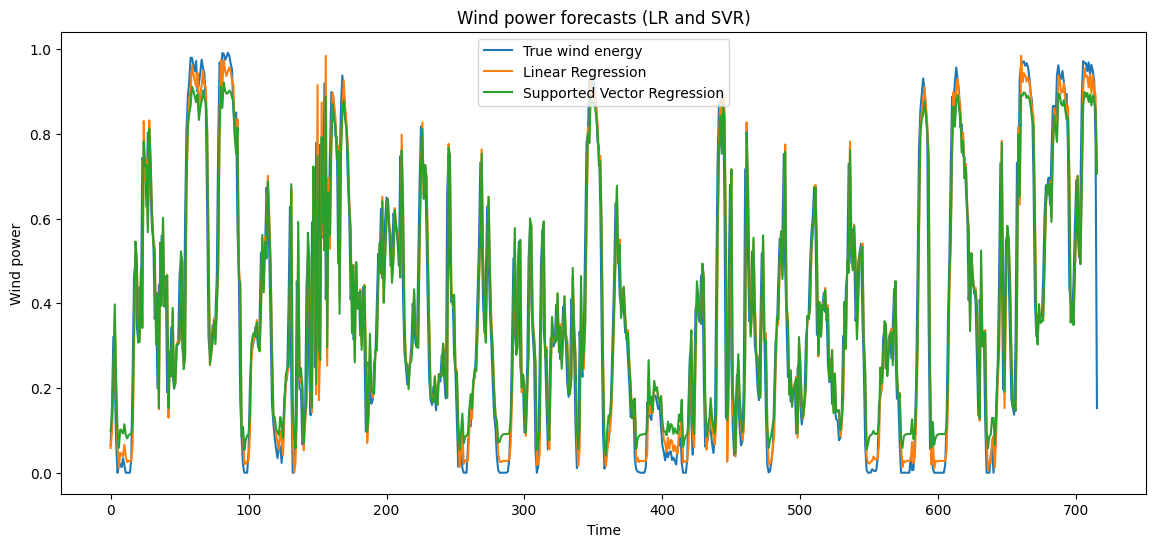

In [50]:
# Plot the time-series figure for LR and SVR
plt.figure(figsize=(14, 6))
plt.plot(real_power[windowsize:], label="True wind energy")
plt.plot(lr[0], label="Linear Regression")
plt.plot(svr[0], label="Supported Vector Regression")
plt.xlabel("Time")
plt.ylabel("Wind power")
plt.title("Wind power forecasts (LR and SVR)")
plt.legend()
plt.show()

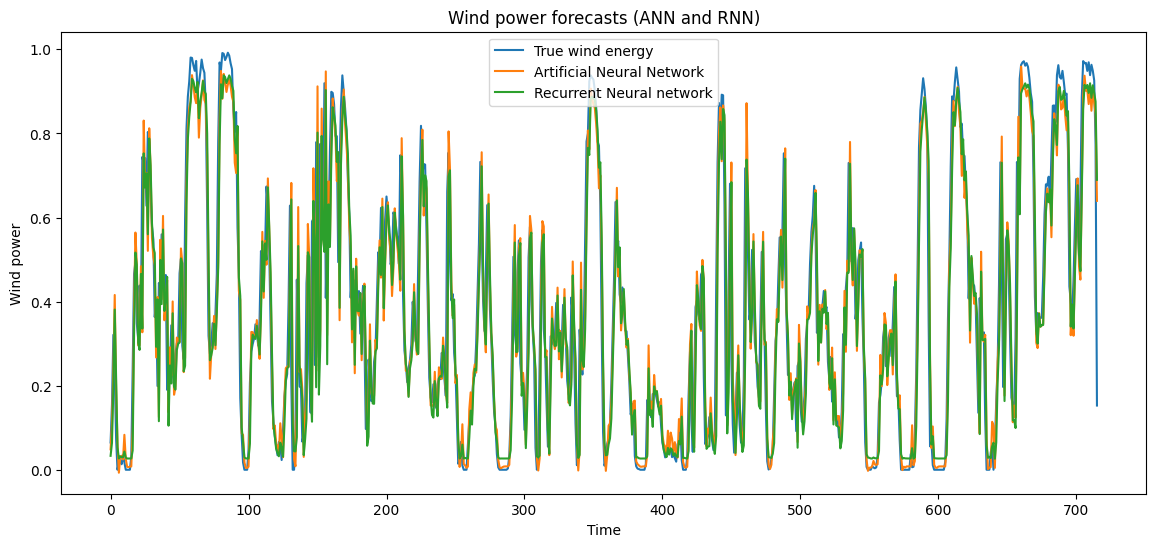

In [51]:
# Plot the time-series figure for ANN and RNN
plt.figure(figsize=(14, 6))
plt.plot(real_power[windowsize:], label="True wind energy")
plt.plot(ann[0], label="Artificial Neural Network")
plt.plot(rnn[0], label="Recurrent Neural network")
plt.xlabel("Time")
plt.ylabel("Wind power")
plt.title("Wind power forecasts (ANN and RNN)")
plt.legend()
plt.show()

In [52]:
# Table for presenting and comparing forecasting accuracy
table = [["LR", lr[1]], ["SVR", svr[1]], ["ANN", ann[1]], ["RNN", rnn[1]]]
table = tabulate(table, headers=["Model", "RMSE"], tablefmt="pretty")
print(table)

+-------+---------------------+
| Model |        RMSE         |
+-------+---------------------+
|  LR   | 0.12325382890412961 |
|  SVR  | 0.12318575594176738 |
|  ANN  | 0.12118813734839019 |
|  RNN  | 0.12277576042464035 |
+-------+---------------------+
